# Analysis of HOIs generated with a simple operation as multiplication or copy

In the following lines we reproduce a simple scenario in which we have 6 features, 3 of them presenting some interdependencies with a target and 3 of them independent from the target. For instance in the case presented in this notebook, we have: 
 
 - a redundant/synergistic interaction between variables 0,1,2 and the target; 
 
 - a synergystic/redundant interaction within the multiplet of variables 3,4,5 that is independent from the target.

 We also generate the evolution of this interdependencies on a third dimension, following the shape of an hanning window.

In [1]:
import numpy as np
from numpy import random
import hoi
import matplotlib.pyplot as plt
import xgi
from frites.utils import parallel_func

#path_results='/home/INT/neri.m/results/'
#path_figures='/home/INT/neri.m/figures/'

path="C:/Users/matte/Codes/"
path_results='C:/Users/matte/Codes/results/'
path_figures='C:/Users/matte/Codes/figures/'

from utils import oinfo_min, goinfo_create_fit, goinfo_create_fit_correction, task_oinfo_create_fit_correction

In [2]:

#the target variable can be multivariate
target = random.multivariate_normal([0,0],[[1,0],[0,1]], 300).T
n_samples = 300
n_features = 12

data = np.zeros((n_features, n_samples))

data[0] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[1] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[2] =  random.normal(loc=0.0, scale=1.0, size=n_samples)

target[0] = (data[0] + data[1] + data[2])

data[3] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[4] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[5] = data[3] + data[4]

data[6] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]
data[7] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]
data[8] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]


data[9] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[10] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + data[9]
data[11] = random.normal(loc=0.0, scale=1.0, size=n_samples) + data[9]

data = data.T

#Here we generate the evolution on a third dimension, that can be the imagined as the time in a neuroscientific framework.
n_variable = 100
variables=np.arange(100)

data_random=np.broadcast_to(np.random.multivariate_normal(np.zeros(n_features), np.identity(n_features), n_samples)[:,:,np.newaxis], (n_samples, n_features, n_variable))

#hanning windows that we used to model the evolution of the interdependencies on a third dim
han = np.broadcast_to(np.hanning(n_variable), (n_samples, n_features, n_variable))

data_features = np.broadcast_to(data[:,:,np.newaxis], (n_samples, n_features, n_variable))* han + (1-han) * data_random


A simple plot of the data across trials

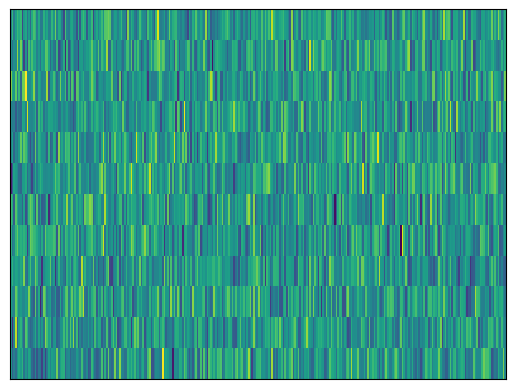

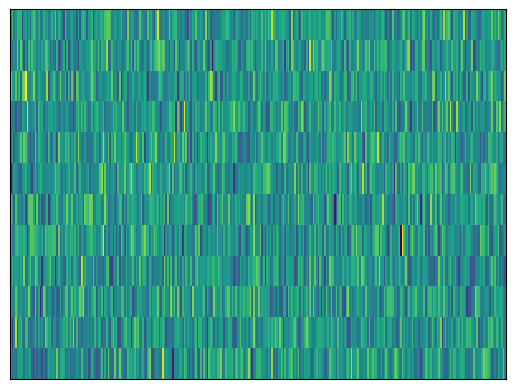

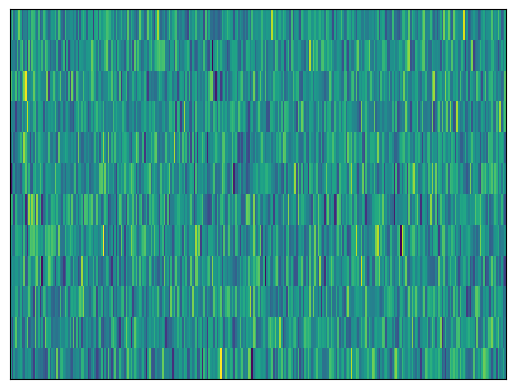

In [3]:
for i in [0,10,20]:
    plt.imshow(data_features[:,:,i].T, aspect='auto', interpolation='none', cmap='viridis')
    #plt.yticks(np.arange(12), np.arange(12), rotation=60, fontsize=12)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    plt.close()

In [3]:
pv=np.load( path_results+'pvalues_simulations.npy')
perm=np.load( path_results+'perm_simulations.npy')
g=np.load(path_results+'results_correctgoinfo_simulations.npy')

In [4]:

effect_list=[g[np.newaxis, i,:] for i in range(len(g[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(g[:,0]))]

In [5]:
from frites.workflow import WfStats


In [6]:
inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)
# Mean II across subjects


Definition of a non-parametric statistical workflow
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=0; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.0007953643798828125; tail=0)


In [7]:
model=hoi.metrics.GradientOinfo(data_features, y=target.T)
combos=model.get_combinations(minsize=2, maxsize=6)[0]
list_indices=[[int(c) for c in comb if c != -1] for comb in combos]
list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]



Get list of multiplets


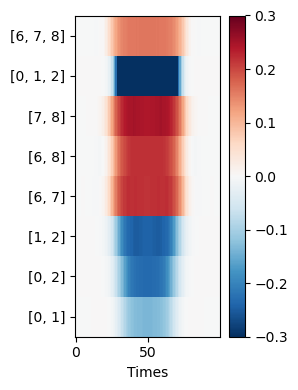

In [9]:
p_values1=np.where(pv.T<0.003,1,0)
vmax=0.3
vmin= -vmax
plt.figure(figsize=(3,4))
index=np.where(np.sum(np.abs(g*p_values1), axis=1)>0)[0]
#plt.pcolormesh(    variables, np.array([comb[:-9] + "]" for comb in list_multiplets])[index], goinfo[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.pcolormesh(
    variables, np.array(list_multiplets)[index], g[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.tight_layout()
plt.savefig(path_figures+'results_sim_multxtime.png', dpi=600)
plt.show()
plt.close()

In [7]:
res_final=goinfo*p_values1

In [10]:
from utils import centrality_nodes

In [12]:
node_centr=centrality_nodes(res_final, np.arange(12), list_indices)
node_centr=np.array(node_centr)
nodesize=np.abs(node_centr.mean(1))

NameError: name 'res_final' is not defined

In [16]:
aa=g[index, :].mean(1)
ll=[i[:-2] for j, i in enumerate(list_indices) if j in index]
ll=[i for j, i in enumerate(list_indices) if j in index]
node_label={i:str(i) for i in range(12)}


In [18]:
weighted_hypergraph_to_plot=xgi.Hypergraph()
weighted_hypergraph_to_plot.add_nodes_from([0,1,2,3,4,5,6,7,8,9,10,11])
weighted_hypergraph_to_plot.add_edges_from(ll)


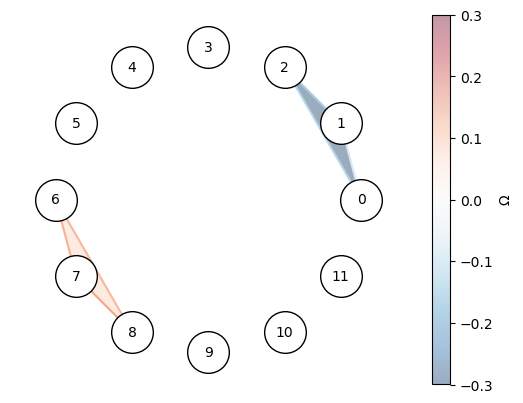

In [24]:
ax, collection = xgi.draw(weighted_hypergraph_to_plot,
                 node_labels=True,
                 node_size=30,
                 pos={i:[np.cos(x)/4, np.sin(x)/4] for i, x in enumerate(np.arange(0,2*np.pi, 2*np.pi/12))},
                 dyad_color=aa[:-2],
                 dyad_color_cmap='RdBu_r',
                 dyad_vmin=-.3,
                 dyad_vmax=.3,
                 edge_fc=aa[-2:], 
                 edge_fc_cmap='RdBu_r', 
                 edge_vmin=-.3,
                 edge_vmax=.3)


_, dyad_col, edge_col = collection

#plt.colorbar(dyad_col, label="dyad degree")
plt.colorbar(edge_col, label="$\Omega$")
